In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import comb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('final-project-baseline-values.xlsx', names=['metrics', 'value'], header=None)
df

,metrics,value
0,Unique cookies to view page per day:,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,"Probability of enrolling, given click:",0.206250
5,"Probability of payment, given enroll:",0.530000
6,"Probability of payment, given click",0.109313


In [3]:
# Calculate standard deviation of evaluation metrics given a sample of 5000 cookies
baseline = {'cookies': 5000,
            'click': 400,
            'enrollment': 82.5,
            'CTP': 0.08,
            'GC': 0.20625,
            'R': 0.53,
            'NC': 0.109313}

In [4]:
std_GC = np.sqrt(baseline['GC']*(1-baseline['GC'])/baseline['click'])
std_R = np.sqrt(baseline['R']*(1-baseline['R'])/baseline['enrollment'])
std_NC = np.sqrt(baseline['NC']*(1-baseline['NC'])/baseline['click'])

In [5]:
[std_GC, std_R, std_NC]

[0.020230604137049392, 0.05494901217850908, 0.015601575884425905]

In [6]:
# Sample size using online calculator
sample_size_calculator = {'GC': [25835, round(25835/baseline['CTP']*2)],
                          'R': [39115, round(39115/baseline['GC']/baseline['CTP']*2)],
                          'NC': [27413, round(27413/baseline['CTP']*2)]}

sample_size_calculator = pd.DataFrame.from_dict(sample_size_calculator, orient='index', columns=['Sample_size', 'Number_of_cookies'])
sample_size_calculator

,Sample_size,Number_of_cookies
GC,25835,645875
R,39115,4741212
NC,27413,685325


In [7]:
# Sanity Check
ctrl = pd.read_excel('Final+Project+Results.xlsx', 0, index_col=0)
exp = pd.read_excel('Final+Project+Results.xlsx', 1, index_col=0)

In [8]:
# Pageviews
pageviews_ctrl = ctrl.Pageviews.sum()
pageviews_exp = exp.Pageviews.sum()
pageviews_total = pageviews_ctrl + pageviews_exp
stats_pageviews = (pageviews_ctrl/pageviews_total - 0.5)/np.sqrt((0.5**2/pageviews_total))
p_pageviews = 1-stats.norm.cdf(stats_pageviews) # stats_pageviews > 0
p_pageviews

0.14392482085331415

In [9]:
# Clicks
click_ctrl = ctrl.Clicks.sum()
click_exp = exp.Clicks.sum()
click_total = click_ctrl + click_exp
stats_click = (click_ctrl/click_total - 0.5)/np.sqrt((0.5**2/click_total))
p_click = 1-stats.norm.cdf(stats_click) # stats_click > 0
p_click

0.41193385199077437

In [10]:
# Click Through Probability
CTP_ctrl = click_ctrl/pageviews_ctrl
CTP_exp = click_exp/pageviews_exp
CTP_pool = click_total/pageviews_total
CTP_std = np.sqrt(CTP_pool*(1-CTP_pool)*(1/pageviews_ctrl + 1/pageviews_exp))
stats_CTP = (CTP_ctrl-CTP_exp)/CTP_std
p_CTP = stats.norm.cdf(stats_CTP) # stats_CTP < 0
p_CTP

0.4658679762236956

In [11]:
# Effect Size Tests
# Gross Conversion
GC_clicks_ctrl = ctrl.loc[ctrl.Enrollments.notnull(), 'Clicks'].sum()
GC_clicks_exp = exp.loc[exp.Enrollments.notnull(), 'Clicks'].sum()
GC_ctrl = ctrl.Enrollments.sum()/GC_clicks_ctrl
GC_exp = exp.Enrollments.sum()/GC_clicks_exp
GC_diff = GC_exp-GC_ctrl
GC_pooled = (ctrl.Enrollments.sum()+exp.Enrollments.sum())/(GC_clicks_ctrl+GC_clicks_exp)
GC_std = np.sqrt(GC_pooled*(1-GC_pooled)*(1/GC_clicks_ctrl+1/GC_clicks_exp))
stats_GC = GC_diff/GC_std
p_GC = stats.norm.cdf(stats_GC) # stats_GC < 0
p_GC

1.2892005168602965e-06

In [12]:
CI_GC = [GC_diff-stats.norm.ppf(1-0.05/2)*GC_std, GC_diff+stats.norm.ppf(1-0.05/2)*GC_std]
CI_GC

[-0.02912320088750467, -0.011986548273218463]

In [13]:
# Net Conversion
NC_ctrl = ctrl.Payments.sum()/GC_clicks_ctrl
NC_exp = exp.Payments.sum()/GC_clicks_exp
NC_diff = NC_exp-NC_ctrl
NC_pooled = (ctrl.Payments.sum()+exp.Payments.sum())/(GC_clicks_ctrl+GC_clicks_exp)
NC_std = np.sqrt(NC_pooled*(1-NC_pooled)*(1/GC_clicks_ctrl+1/GC_clicks_exp))
stats_NC = NC_diff/NC_std
p_NC = stats.norm.cdf(stats_NC) # stats_NC < 0
p_NC

0.07792034131075103

In [14]:
CI_NC = [NC_diff-stats.norm.ppf(1-0.05/2)*NC_std, NC_diff+stats.norm.ppf(1-0.05/2)*NC_std]
CI_NC

[-0.011604500677993734, 0.0018570553289053993]

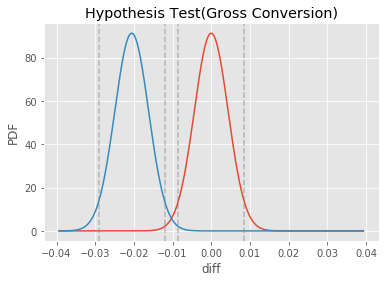

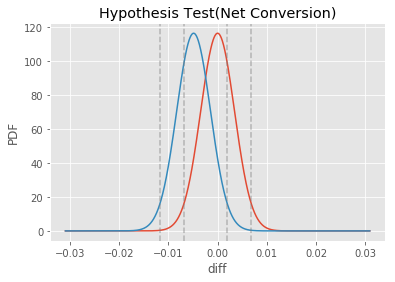

In [15]:
# Visualize Hypothesis Test
def abplot(diff, std, alpha=0.05, title=None):
    plt.style.use('ggplot')

    fig, ax = plt.subplots()
    x = np.linspace(-9*std, 9*std, 1000)
    y1 = stats.norm(0, std).pdf(x)
    y2 = stats.norm(diff, std).pdf(x)
    
    ax.plot(x, y1)
    ax.plot(x, y2)
    
    z_score = stats.norm.ppf(1-alpha/2)
    ax.axvline(-std*z_score, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(std*z_score, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(diff-std*z_score, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(diff+std*z_score, color='grey', linestyle='--', alpha=0.5)
    
    plt.xlabel('diff')
    plt.ylabel('PDF')
    if not title:
        plt.title('Hypothesis Test')
    else:
        plt.title('Hypothesis Test('+title+')')
    plt.show

abplot(GC_diff, GC_std, title='Gross Conversion')
abplot(NC_diff, NC_std, title='Net Conversion')

In [16]:
# Sign Test
ST = ctrl.merge(exp, left_index=True, right_index=True)
ST = ST.loc[ST.Payments_x.notnull(),:]
ST['GC'] = ST['Enrollments_y']/ST['Clicks_y'] > ST['Enrollments_x']/ST['Clicks_x']
ST['NC'] = ST['Payments_y']/ST['Clicks_y'] > ST['Payments_x']/ST['Clicks_x']

def sign_test(x, n):
    def binomial(x, n):
        return comb(n,x)*0.5**n
    p = 0
    for i in range(x+1):
        p = p + binomial(i, n)
    return p

In [17]:
# Gross Conversion
p_GC_ST = 2 * sign_test(ST['GC'].sum(), ST['GC'].count())
p_GC_ST

0.002599477767944336

In [18]:
# Net Conversion
p_NC_ST = 2 * sign_test(ST['NC'].sum(), ST['NC'].count())
p_NC_ST

0.6776394844055176